In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import torch
from torch import nn
from torch.autograd import Variable

In [2]:
# Reading the train, test and RUL files (FD001 dataset)
df_train = pd.read_csv(r"data\train_FD001.txt", sep = ' ', header = None)
df_test = pd.read_csv(r"data\test_FD001.txt", sep = ' ', header = None)
df_RUL = pd.read_csv(r"data\RUL_FD001.txt", header = None)
col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
df_train = df_train[list(range(26))]
df_train.columns = col_list
df_test = df_test[list(range(26))]
df_test.columns = col_list

In [3]:
# 剔除方差为0的项
new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
df_train = df_train[new_col_list]
df_test = df_test[new_col_list]
# 归一化
scale_col_list = new_col_list[2:]
df_train[scale_col_list] = minmax_scale(df_train[scale_col_list])
df_test[scale_col_list] = minmax_scale(df_test[scale_col_list])

In [4]:
# 测试集最小长度为31，所以设置学习的序列长度为31
seq_selected = min(df_test.groupby('unit').max()['time'])
print("The mimium length of the sequence in test dataset is", seq_selected)

The mimium length of the sequence in test dataset is 31


In [5]:
# Preparation of inputs for training
max_list = list(df_train.groupby('unit').max()['time'])     # creating a list of max cycles in the training dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
i = 0
X_train = Variable(torch.Tensor([]).float()).to(device)
for item in max_list:
  temp_list = Variable(torch.Tensor([]).float()).to(device)
  for j in range(item - seq_selected):
      zero_list = Variable(torch.Tensor(df_train.values[i+j:i+j+seq_selected, [4,5,6,8,9,11,12,13,15,16,17,18]]).float()).to(device)
      temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 12)), dim=0)#去掉cycle后为12
  i += item
  X_train = torch.cat((X_train, temp_list), dim=0)

print("The shape of input data for training model, X_train is", X_train.shape)

The shape of input data for training model, X_train is torch.Size([17531, 31, 12])


In [6]:
# Preparation of labels for training

y_train = []
for item in max_list:
  y_train.extend(list(range(item-seq_selected))[::-1])
y_train = Variable(torch.Tensor(y_train).float()).to(device)
y_train = y_train.view(X_train.shape[0], 1)

print("The shape of labels data for training model, y_train is", y_train.shape)

The shape of labels data for training model, y_train is torch.Size([17531, 1])


In [7]:
# Model parameters
batch_size = 256
num_epochs = 150
hidden_dim = 100
hidden_dim2 = 50
input_size=12

In [8]:
class bilstm_am(nn.Module):
    def __init__(self):
        super(bilstm_am, self).__init__()
        self.lstm1 = nn.LSTM(
            batch_first=True,
            input_size=12,          # Input features: 12
            hidden_size=100,        # First LSTM hidden units: 100
            num_layers=1,
            bidirectional=True
        )
        self.lstm2 = nn.LSTM(
            batch_first=True,
            input_size=200,         # Input features = 100 * 2 (bidirectional)
            hidden_size=100,        # Second LSTM hidden units: 100
            num_layers=1,
            bidirectional=True
        )
        self.dropout = nn.Dropout(p=0.2)

        # Attention mechanism remains the same
        self.attention = TimeAwareAttention(seq_length=seq_selected)

        # Batch normalization added
        self.batch_norm = nn.BatchNorm1d(num_features=seq_selected * 200)

        # Fully connected layers
        self.linear = nn.Sequential(
            nn.Linear(seq_selected * 200, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(100, 50),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

        self.mslinear = nn.Sequential(
            nn.Linear(24, 10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1)
        )

        self.output = nn.Sequential(
            nn.Linear(20, 1)        # Final output layer
        )

    def forward(self, inputs):  # Input shape: (batch_size, seq_selected, 12)
        # Statistical feature branch
        mean = torch.mean(inputs, dim=1)       # Shape: (batch_size, 12)
        std = torch.std(inputs, dim=1)        # Shape: (batch_size, 12)
        mean_std_feature = torch.cat((mean, std), dim=1)  # Shape: (batch_size, 24)
        y = self.mslinear(mean_std_feature)  # Shape: (batch_size, 10)

        # Bidirectional LSTM branch
        x, _ = self.lstm1(inputs)    # First LSTM output: (batch_size, seq_selected, 200)
        x, _ = self.lstm2(x)         # Second LSTM output: (batch_size, seq_selected, 200)
        x = self.dropout(x)          # Apply Dropout
        x = self.attention(x)        # Attention weighted output: (batch_size, seq_selected, 200)

        # Flatten and apply batch normalization
        x = x.reshape(-1, seq_selected * 200)  # Shape: (batch_size, seq_selected * 200)
        x = self.batch_norm(x)                 # Apply BatchNorm1d
        x = self.linear(x)                     # Fully connected layers: (batch_size, 10)

        # Combine features and output the RUL prediction
        out = torch.cat((x, y), dim=1)         # Shape: (batch_size, 20)
        out = self.output(out)                 # Shape: (batch_size, 1)
        return out

class TimeAwareAttention(nn.Module):
    def __init__(self, seq_length):
        super().__init__()
        self.seq_length = seq_length
        # Learnable parameter to assign weights to different time steps
        self.time_weight = nn.Parameter(torch.ones(seq_length))
        self.softmax = nn.Softmax(dim=0)  # Correct dimension for softmax on 1D tensor

    def forward(self, inputs):
        # inputs shape: (batch_size, seq_length, feature_dim)
        batch_size, seq_length, feature_dim = inputs.shape

        # Compute time step weights (higher for later steps)
        time_weights = self.softmax(self.time_weight)  # Shape: (seq_length,)
        time_weights = time_weights.view(1, self.seq_length, 1)  # Expand to (1, seq_length, 1)

        # Apply weights to inputs
        weighted_inputs = inputs * time_weights  # Shape: (batch_size, seq_length, feature_dim)
        return weighted_inputs


# 初始化模型
torch.manual_seed(114514)
model = bilstm_am().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
savepth = "bilstm_am"
# model

Training model: bilstm_am
Epoch [1/150], Loss: 2363.7410, RMSE: 48.4204
Epoch [6/150], Loss: 1077.5051, RMSE: 33.5602
Epoch [11/150], Loss: 1258.0065, RMSE: 34.2656
Epoch [16/150], Loss: 737.3436, RMSE: 33.0576
Epoch [21/150], Loss: 1064.9108, RMSE: 34.0477
Epoch [26/150], Loss: 1034.1855, RMSE: 35.5716
Epoch [31/150], Loss: 1773.1986, RMSE: 31.3042
Epoch [36/150], Loss: 1157.2393, RMSE: 31.5339
Epoch [41/150], Loss: 965.3489, RMSE: 30.9065
Epoch [46/150], Loss: 713.1473, RMSE: 32.4351
Epoch [51/150], Loss: 954.7162, RMSE: 30.7293
Epoch [56/150], Loss: 770.6685, RMSE: 30.4313
Epoch [61/150], Loss: 910.4163, RMSE: 29.4271
Epoch [66/150], Loss: 867.0674, RMSE: 29.3502
Epoch [71/150], Loss: 634.7266, RMSE: 25.9051
Epoch [76/150], Loss: 532.4462, RMSE: 21.5490
Epoch [81/150], Loss: 438.0322, RMSE: 19.2805
Epoch [86/150], Loss: 357.6383, RMSE: 18.3414
Epoch [91/150], Loss: 182.2785, RMSE: 14.5280
Epoch [96/150], Loss: 237.0422, RMSE: 14.7215
Epoch [101/150], Loss: 162.3864, RMSE: 13.2280
Ep

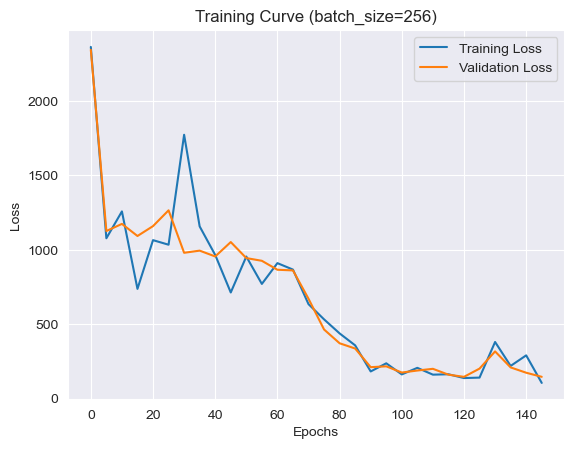

In [9]:
# 训练模型
print(f"Training model: {savepth}")
model.train()
train_loss = []
val_loss = []
epochs = []

for epoch in range(num_epochs):
    # 生成随机索引划分训练集和验证集（保留原始逻辑）
    permutation = torch.randperm(X_train.size(0))
    val_permutation = permutation[:X_train.size(0)//3]    # 验证集（1/3数据）
    train_permutation = permutation[X_train.size(0)//3:]  # 训练集（2/3数据）
    
    # 分批次训练
    for i in range(0, len(train_permutation), batch_size):
        # 清空梯度
        optimizer.zero_grad()
        
        # 获取当前批次数据索引
        indices = train_permutation[i:i+batch_size]
        batch_x = X_train[indices]
        
        # 前向传播
        out = model(batch_x)
        loss = criterion(out, y_train[indices])
        
        # 验证集损失计算（每个epoch结束时计算一次）
        with torch.no_grad():
            val_predict = model(X_train[val_permutation])
            val_loss_cal = criterion(val_predict, y_train[val_permutation])
        
        # 反向传播与优化
        loss.backward()
        optimizer.step()
    
    # 每5个epoch记录损失
    if epoch % 5 == 0:
        train_loss.append(loss.item())
        val_loss.append(val_loss_cal.item())
        epochs.append(epoch)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {torch.sqrt(val_loss_cal).item():.4f}')

# 绘制训练曲线
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title(f"Training Curve (batch_size={batch_size})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# Preparing Test data
max_list_test = list(df_test.groupby('unit').max()['time'])
i = 0
X_test = Variable(torch.Tensor([]).float()).to(device)
for item in max_list_test:
  temp_list = Variable(torch.Tensor([]).float()).to(device)
  zero_list = Variable(torch.Tensor(df_test.values[i + item - seq_selected : i + item, [4,5,6,8,9,11,12,13,15,16,17,18]]).float()).to(device)
  temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, input_size)), dim=0)
  i += item
  X_test = torch.cat((X_test, temp_list), dim=0)

print(X_test.shape)

torch.Size([100, 31, 12])


In [11]:
# Preparing test labels

y_test = df_RUL.values
y_test = Variable(torch.Tensor(y_test).float()).to(device)
# Predicting loss on the test dataset
model.eval()
y_pred = model(X_test)
test_loss = criterion(y_pred, y_test)

print("The loss on test data is", test_loss.item())
print("The RMSE on test data is", torch.sqrt(test_loss).item())

The loss on test data is 1019.3529052734375
The RMSE on test data is 31.927305221557617


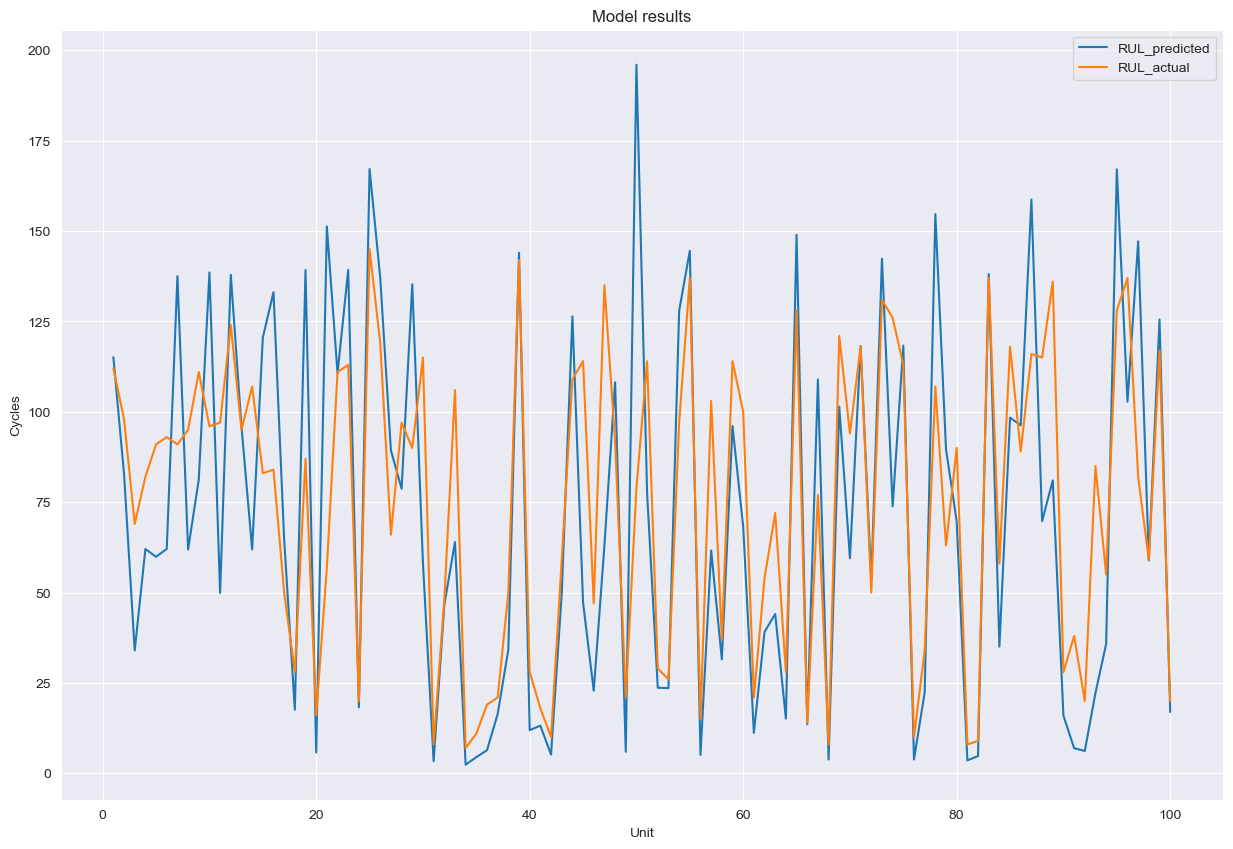

In [12]:
# Plotting predicted vs actual RULs

plt.figure(figsize=(15,10))
plt.plot(list(range(1,101)), y_pred.view(100).tolist(), label='RUL_predicted')
plt.plot(list(range(1,101)), y_test.view(100).tolist(), label="RUL_actual")
plt.title("Model results")
plt.xlabel("Unit")
plt.ylabel("Cycles")
plt.legend()
plt.show()